## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.001, 0.0001]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=0.5, 
                                  min_lr=reduce_factor, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0731 16:59:17.590619 4798698944 deprecation_wrapper.py:119] From /Users/samir/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 16:59:17.591845 4798698944 deprecation_wrapper.py:119] From /Users/samir/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 16:59:17.690480 4798698944 deprecation_wrapper.py:119] From /Users/samir/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0731 16:59:17.709207 4798698944 deprecation_wrapper.py:119] From /Users/samir/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf

Numbers of exp: 0, reduce_factor: 0.00, reduce_patient: 5


W0731 16:59:18.123418 4798698944 deprecation_wrapper.py:119] From /Users/samir/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0731 16:59:18.143883 4798698944 deprecation_wrapper.py:119] From /Users/samir/anaconda3/envs/tensorflow/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0731 16:59:18.267194 4798698944 deprecation.py:323] From /Users/samir/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
__________

50000/50000 [==============================] - 5s 106us/step - loss: 1.2642 - acc: 0.5594 - val_loss: 1.4920 - val_acc: 0.4755
Epoch 12/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.2371 - acc: 0.5682 - val_loss: 1.4839 - val_acc: 0.4761
Epoch 13/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.2116 - acc: 0.5795 - val_loss: 1.4778 - val_acc: 0.4788
Epoch 14/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.1865 - acc: 0.5881 - val_loss: 1.4743 - val_acc: 0.4816
Epoch 15/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.1625 - acc: 0.5983 - val_loss: 1.4722 - val_acc: 0.4836
Epoch 16/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.1389 - acc: 0.6067 - val_loss: 1.4682 - val_acc: 0.4854
Epoch 17/25
50000/50000 [==============================] - 6s 130us/step - loss: 1.1171 - acc: 0.6157 - val_loss: 1.4655 - val_acc: 0.4868
Epoch 18/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 140us/step - loss: 2.3093 - acc: 0.2528 - val_loss: 1.9459 - val_acc: 0.3466
Epoch 2/25
50000/50000 [==============================] - 9s 176us/step - loss: 1.7571 - acc: 0.3893 - val_loss: 1.7448 - val_acc: 0.3962
Epoch 3/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.6182 - acc: 0.4342 - val_loss: 1.6591 - val_acc: 0.4198
Epoch 4/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.5387 - acc: 0.4624 - val_loss: 1.6120 - val_acc: 0.4352
Epoch 5/25
50000/50000 [==============================] - 5s 106us/step - loss: 1.4804 - acc: 0.4804 - val_loss: 1.5789 - val_acc: 0.4472
Epoch 6/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.4313 - acc: 0.4994 - val_loss: 1.5549 - val_acc: 0.4511
Epoch 7/25
50000/50000 [==============================] - 5s 107us/step - loss: 1.3886 - acc: 0.5144 - val_loss: 1.5332 - 

50000/50000 [==============================] - 6s 126us/step - loss: 0.2418 - acc: 0.9234 - val_loss: 2.0803 - val_acc: 0.5151
Epoch 22/25
50000/50000 [==============================] - 6s 120us/step - loss: 0.2086 - acc: 0.9367 - val_loss: 2.1536 - val_acc: 0.5126
Epoch 23/25
50000/50000 [==============================] - 7s 133us/step - loss: 0.1831 - acc: 0.9453 - val_loss: 2.2179 - val_acc: 0.5132
Epoch 24/25
50000/50000 [==============================] - 6s 126us/step - loss: 0.1629 - acc: 0.9523 - val_loss: 2.2813 - val_acc: 0.5142
Epoch 25/25
50000/50000 [==============================] - 7s 138us/step - loss: 0.1438 - acc: 0.9587 - val_loss: 2.3065 - val_acc: 0.5149

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.001.
Numbers of exp: 5, reduce_factor: 0.00, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0     

50000/50000 [==============================] - 7s 138us/step - loss: 1.2360 - acc: 0.5602 - val_loss: 1.3803 - val_acc: 0.5047
Epoch 6/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.1682 - acc: 0.5842 - val_loss: 1.3670 - val_acc: 0.5127
Epoch 7/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.1028 - acc: 0.6083 - val_loss: 1.3358 - val_acc: 0.5262
Epoch 8/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.0437 - acc: 0.6277 - val_loss: 1.3496 - val_acc: 0.5230
Epoch 9/25
50000/50000 [==============================] - 6s 120us/step - loss: 0.9863 - acc: 0.6493 - val_loss: 1.3545 - val_acc: 0.5287
Epoch 10/25
50000/50000 [==============================] - 7s 134us/step - loss: 0.9361 - acc: 0.6674 - val_loss: 1.3679 - val_acc: 0.5297
Epoch 11/25
50000/50000 [==============================] - 6s 115us/step - loss: 0.8738 - acc: 0.6900 - val_loss: 1.3651 - val_acc: 0.5345
Epoch 12/25
50000/50000 [==================

50000/50000 [==============================] - 6s 127us/step - loss: 0.3717 - acc: 0.9053 - val_loss: 1.6688 - val_acc: 0.5037
Numbers of exp: 8, reduce_factor: 0.00, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_34 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_35 

50000/50000 [==============================] - 6s 126us/step - loss: 0.8894 - acc: 0.6894 - val_loss: 1.5179 - val_acc: 0.4979
Epoch 10/25
50000/50000 [==============================] - 7s 130us/step - loss: 0.8279 - acc: 0.7141 - val_loss: 1.4635 - val_acc: 0.5265
Epoch 11/25
50000/50000 [==============================] - 7s 148us/step - loss: 0.7755 - acc: 0.7316 - val_loss: 1.4137 - val_acc: 0.5293
Epoch 12/25
50000/50000 [==============================] - 7s 149us/step - loss: 0.7158 - acc: 0.7543 - val_loss: 1.4503 - val_acc: 0.5342
Epoch 13/25
50000/50000 [==============================] - 7s 141us/step - loss: 0.6717 - acc: 0.7696 - val_loss: 1.4892 - val_acc: 0.5265
Epoch 14/25
50000/50000 [==============================] - 8s 165us/step - loss: 0.6186 - acc: 0.7890 - val_loss: 1.5508 - val_acc: 0.5213
Epoch 15/25
50000/50000 [==============================] - 9s 178us/step - loss: 0.5724 - acc: 0.8066 - val_loss: 1.6382 - val_acc: 0.5114
Epoch 16/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 168us/step - loss: 1.9333 - acc: 0.3379 - val_loss: 1.7395 - val_acc: 0.4022
Epoch 2/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.5865 - acc: 0.4434 - val_loss: 1.6189 - val_acc: 0.4345
Epoch 3/25
50000/50000 [==============================] - 7s 150us/step - loss: 1.4545 - acc: 0.4929 - val_loss: 1.5452 - val_acc: 0.4590
Epoch 4/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.3631 - acc: 0.5264 - val_loss: 1.5149 - val_acc: 0.4680
Epoch 5/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.2904 - acc: 0.5517 - val_loss: 1.4917 - val_acc: 0.4772
Epoch 6/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.2276 - acc: 0.5746 - val_loss: 1.4639 - val_acc: 0.4837
Epoch 7/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.1725 - acc: 0.5967 - val_loss: 1.4560 - 

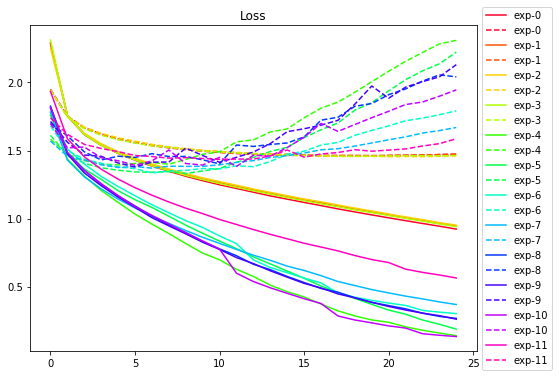

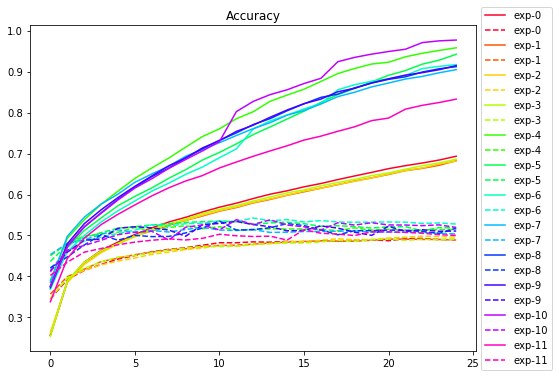

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()